In [1]:
%matplotlib inline 

In [2]:
from random import randint

import numpy as np
from matplotlib import pyplot as plt

from load_data import get_training_data, get_test_data

In [3]:
training_data = get_training_data()
test_data = get_test_data()

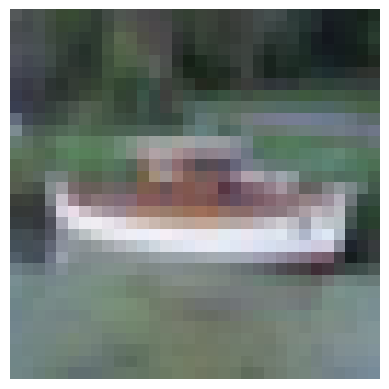

In [4]:
random_index = randint(0, len(training_data["data"]) - 1)
img = training_data["data"][random_index]

# Separate the color channels
red = img[0:1024].reshape((32, 32))
green = img[1024:2048].reshape((32, 32))
blue = img[2048:3072].reshape((32, 32))

# Stack channels along the third dimension
img_rgb = np.stack((red, green, blue), axis=2)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

2024-10-30 16:52:21.187737: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 16:52:22.417114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730269342.909920   30026 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730269343.052765   30026 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 16:52:24.422807: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [6]:
num_classes = 10

my_new_model = Sequential()
my_new_model.add(VGG16(include_top=False, pooling='avg', weights='imagenet'))
my_new_model.add(Dense(num_classes, activation='softmax'))

# Indicate whether the first layer should be trained/changed or not.
my_new_model.layers[0].trainable = False

2024-10-30 16:52:42.223668: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (100)


In [7]:
my_new_model.compile(optimizer='sgd', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

In [8]:
from tensorflow.image import resize
from tensorflow.keras.applications.resnet50 import preprocess_input

image_size = 224

def data_generator(data, labels, batch_size=32):
    num_samples = data.shape[0]

    while True:  # Loop forever so the generator never terminates
        # Shuffle the data at the start of each epoch
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]

            # Initialize batch arrays
            batch_images = []
            batch_labels = []

            for i in batch_indices:
                # Reshape each image from (3072,) to (32, 32, 3)
                img = data[i]
                red = img[0:1024].reshape((32, 32))
                green = img[1024:2048].reshape((32, 32))
                blue = img[2048:3072].reshape((32, 32))
                img_rgb = np.stack((red, green, blue), axis=-1)

                # Resize to (224, 224) for ResNet50
                img_resized = resize(img_rgb, (image_size, image_size)).numpy()

                # Preprocess the image
                img_preprocessed = preprocess_input(img_resized)

                # Append to batch
                batch_images.append(img_preprocessed)
                batch_labels.append(labels[i])

            yield np.array(batch_images), np.array(batch_labels)


# Example usage
train_generator = data_generator(training_data["data"], training_data["labels"], batch_size=10)
validation_generator = data_generator(test_data["data"], test_data["labels"], batch_size=10)

In [9]:
import tensorflow as tf
def memory_efficient_generator(data, labels, batch_size=32):
    num_samples = len(data)
    
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            
            batch_images = []
            batch_labels = []
            
            for i in batch_indices:
                img = data[i]
                # Reshape and resize
                red = img[0:1024].reshape((32, 32))
                green = img[1024:2048].reshape((32, 32))
                blue = img[2048:3072].reshape((32, 32))
                img_rgb = np.stack((red, green, blue), axis=-1)
                img_resized = resize(img_rgb, (image_size, image_size)).numpy()
                img_preprocessed = preprocess_input(img_resized)
                
                batch_images.append(img_preprocessed)
                batch_labels.append(labels[i])
            
            yield np.array(batch_images), tf.keras.utils.to_categorical(batch_labels, num_classes=10)


In [10]:
# fit_stats below saves some statistics describing how model fitting went
# the key role of the following line is how it changes my_new_model by fitting to data
# train_generator = memory_efficient_generator(training_data["data"], training_data["labels"], batch_size=22)
# my_new_model.fit(train_generator, steps_per_epoch=len(training_data["data"]) // 10, epochs=10)

In [12]:
import tensorflow as tf

# Prepare dataset directly from the original images and labels
def preprocess_image(img, label):
    red = img[0:1024].reshape((32, 32))
    green = img[1024:2048].reshape((32, 32))
    blue = img[2048:3072].reshape((32, 32))
    img_rgb = np.stack((red, green, blue), axis=-1)
    
    # Resize and preprocess
    img_resized = tf.image.resize(img_rgb, (image_size, image_size))
    img_preprocessed = preprocess_input(img_resized)
    
    return img_preprocessed, tf.keras.utils.to_categorical(label, num_classes=num_classes)

# Create the tf.data.Dataset for training data
train_dataset = tf.data.Dataset.from_tensor_slices((training_data["data"], training_data["labels"]))
train_dataset = train_dataset.shuffle(buffer_size=len(training_data["data"]))
train_dataset = train_dataset.map(lambda img, label: tf.py_function(preprocess_image, [img, label], [tf.float32, tf.float32]),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Now use train_dataset in fit
my_new_model.fit(train_dataset, epochs=10)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=True
  • mask=None